# <center> 👉 class_13_4 » _Multi Person Pose Estimation - OpenPose_ </center>

## ▣ Multi Person Pose Estimation using OpenPose  

When there are multiple people in a photo, pose estimation produces multiple independent keypoints. 
We need to figure out which set of keypoints belong to the same person.

We will be using the 18 point model trained on the COCO dataset. 
The keypoints along with their numbering used by the COCO Dataset is given below:  
    
COCO Output Format  

    Nose – 0, Neck – 1, Right Shoulder – 2, Right Elbow – 3, Right Wrist – 4,
    Left Shoulder – 5, Left Elbow – 6, Left Wrist – 7, Right Hip – 8,
    Right Knee – 9, Right Ankle – 10, Left Hip – 11, Left Knee – 12,
    LAnkle – 13, Right Eye – 14, Left Eye – 15, Right Ear – 16,
    Left Ear – 17, Background – 18  

In [1]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

## First, we find the keypoints for a image with only single person

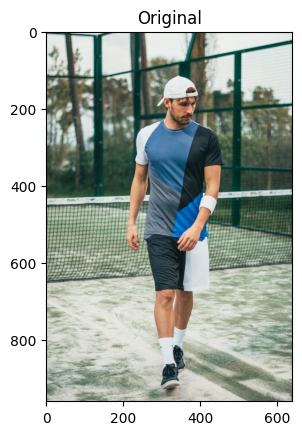

In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

# Specify the paths for the 2 files   
protoFile = "./pose_est/mpi/mpi_pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "./pose_est/mpi_pose_iter_160000.caffemodel"
nPoints = 15
POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)   # Read the network into Memory 

frame = cv2.imread("./images/CV/single.jpeg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

In [3]:
# Pass it through the network
inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]

gather the points and plot the keypoints and the skeleton figure

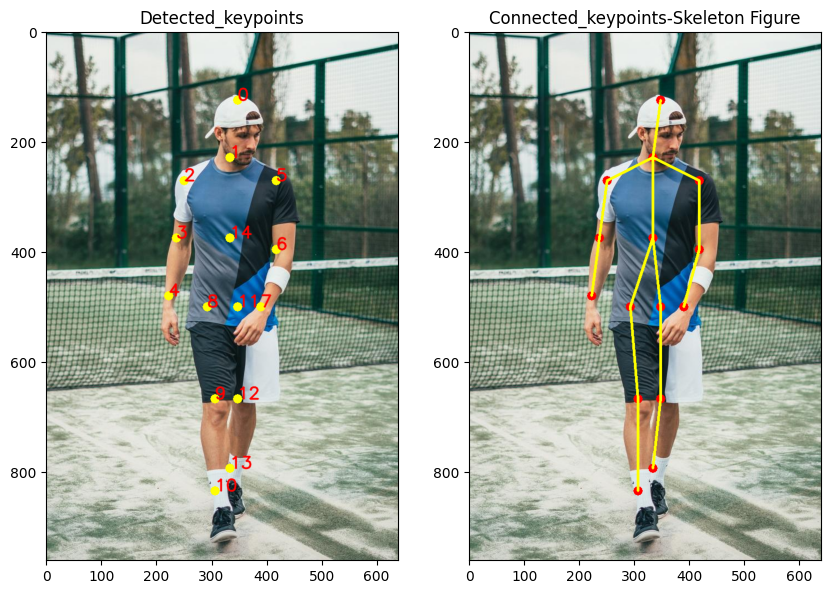

In [4]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.subplot(121),plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB)),plt.title('Detected_keypoints')
plt.subplot(122),plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)),plt.title('Connected_keypoints-Skeleton Figure')
plt.show()

## Multi Person Pose Estimation (split code cell, it may not work)

### 1. Download Model Files (COCO) and Generate Network
- prototxt : "./pose_est/pose_deploy_linevec_faster_4_stages.prototxt"
- caffemodel : "./pose_est/coco_pose_iter_440000.caffemodel"

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

# Specify the paths for the 2 files   
protoFile = './pose_est/pose_deploy_linevec_faster_4_stages.prototxt'
weightsFile = './pose_est/coco_pose_iter_440000.caffemodel' 
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)   # Read the network into Memory 

### 2. Load Image and create input blob

In [2]:
image1 = cv2.imread("./images/CV/people6.webp")
frameHeight=image1.shape[1]
frameWidth=image1.shape[0]
image1.shape

(333, 521, 3)

In [3]:
# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)
 
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

In [4]:
# Forward pass through the Net
net.setInput(inpBlob)
output = net.forward()

- Check the confidence map. 

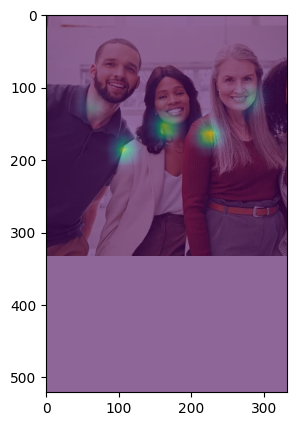

In [5]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=100)
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
 
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.show()

### 3. Detection of keypoints  

In order to find the exact location of the keypoints, we need to find the maxima for each blob. We do the following :

- First find all the contours of the region corresponding to the keypoints.
- Create a mask for this region.
- Extract the probMap for this region by multiplying the probMap with this mask.
- Find the local maxima for this region. This is done for each contour ( keypoint region ).

In [6]:
threshold = 0.1
mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
mapMask = np.uint8(mapSmooth>threshold)

In [7]:
#find the blobs
_, contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
keypoints = []
#for each blob find the maxima
for cnt in contours:
    blobMask = np.zeros(mapMask.shape)
    blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
    maskedProbMap = mapSmooth * blobMask
    _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
    keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

In [8]:
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]] 
POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

### 4. Assemble Person-wise Keypoints

In [ ]:
for j in range(len(personwiseKeypoints)):
    if personwiseKeypoints[j][indexA] == partAs[i]:
        person_idx = j
        found = 1
        break
        
if found:
    personwiseKeypoints[person_idx][indexB] = partBs[i]
    
elif not found and k < 17:
    row = -1 * np.ones(19)
    row[indexA] = partAs[i]
    row[indexB] = partBs[i]    

### 5. plot the skeleton on the input image

In [ ]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 2, cv2.LINE_AA)

cv2.imshow("Detected Pose" , frameClone)
cv2.waitKey(0)
cv2.destroyAllWindows()

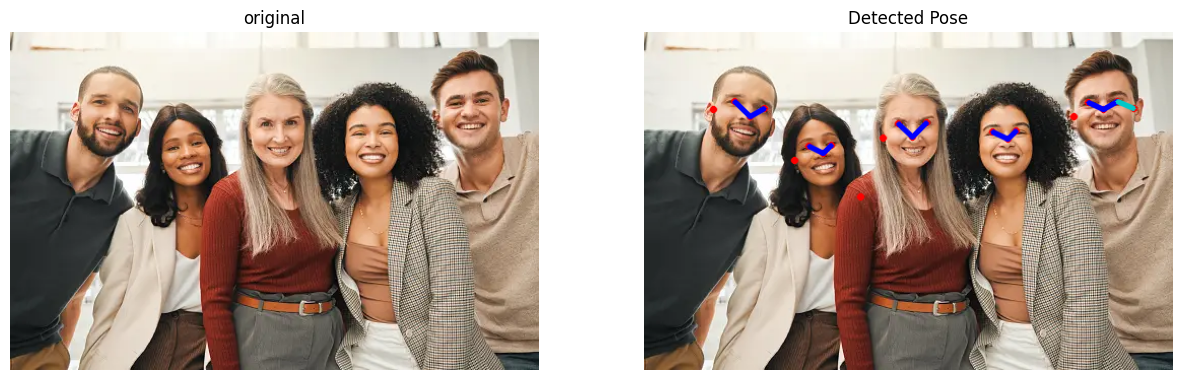

In [74]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)

plt.subplot(121),plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)),plt.title('original'),plt.axis('off')
plt.subplot(122),plt.imshow(cv2.cvtColor(frameClone, cv2.COLOR_BGR2RGB)),plt.title('Detected Pose'),plt.axis('off')
plt.show()

# Multi-Person-Pose-Estimation  (Full Code)

https://github.com/spmallick/learnopencv/blob/master/OpenPose-Multi-Person/multi-person-openpose.ipynb

In [10]:
# learnOpenCV
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint
device = "cpu"          # please change it to "gpu" if the model needs to be run on cuda. 
protoFile = "./pose_est/coco/coco_pose_deploy_linevec.prototxt"
weightsFile = "./pose_est/coco_pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    _, contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [11]:
# Find valid connections between the different joints of a all persons present

def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
#             print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
#     print(valid_pairs)
    return valid_pairs, invalid_pairs

# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. 
# This can be done since we have an id for each joint

def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [12]:
# image1 = cv2.imread("./images/CV/people6.webp")
image1 = cv2.imread("./images/CV/people6.webp")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

Load the network and pass the image through the network

In [13]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Using CPU device
Time Taken = 5.878367900848389


Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

In [14]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))

(-0.5, 520.5, 332.5, -0.5)

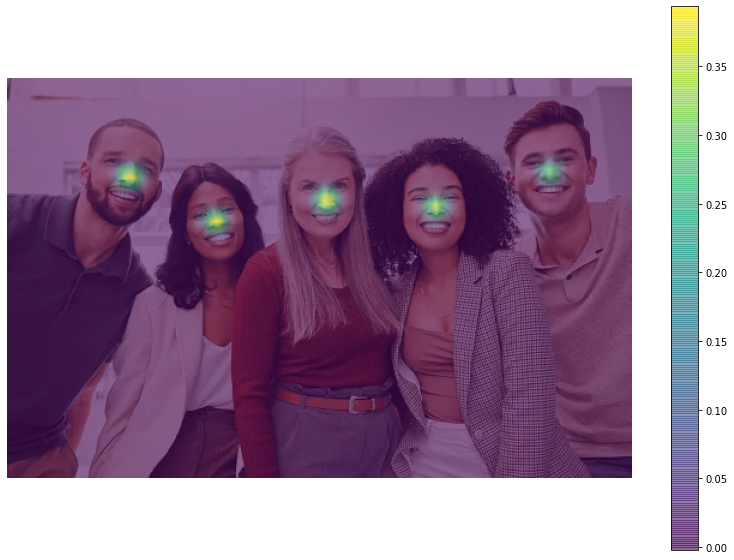

In [15]:
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [23]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
#     print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))

    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)
    
frameClone = image1.copy()

for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
cv2.imshow("Keypoints",frameClone)
image_dot=frameClone.copy()
valid_pairs, invalid_pairs = getValidPairs(output)
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)

cv2.imshow("Detected Pose" , frameClone)
cv2.waitKey(0)
cv2.destroyAllWindows()

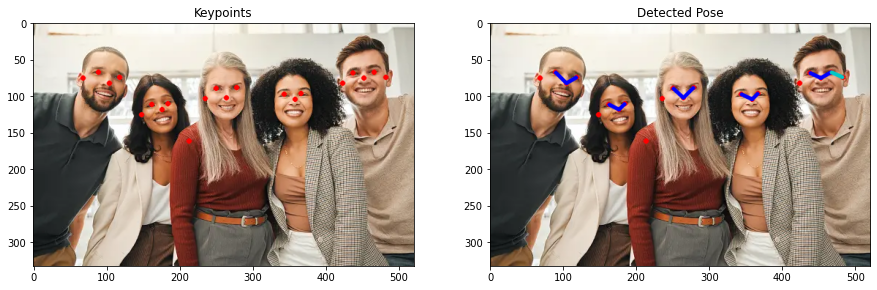

In [27]:
plt.figure(figsize=[15,15])
plt.subplot(121),plt.imshow(cv2.cvtColor(image_dot, cv2.COLOR_BGR2RGB)),plt.title('Keypoints')
plt.subplot(122),plt.imshow(cv2.cvtColor(frameClone, cv2.COLOR_BGR2RGB)),plt.title('Detected Pose') # frameClone[:,:,[2,1,0]]
plt.show()